In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [36]:
df=pd.read_csv('../../data/learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=42)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [37]:
class DNN_3(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_3, self).__init__()
        self.layer1 = nn.Linear(input_dim,64)
        self.layer2 = nn.Linear(64,32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, 8)
        self.output_layer = nn.Linear(8, 1)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)        
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        
        x = torch.relu(self.layer2(x))
        x = self.dropout1(x)

        x = torch.relu(self.layer3(x))
        x = self.dropout2(x)

        x = torch.relu(self.layer4(x))
    

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [38]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=4, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=4, shuffle=False)

Optunaの設定

In [39]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   

    # モデル定義
    model = DNN_3(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >0.49).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 最終的な評価指標を計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [40]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-04 16:04:11,965] A new study created in memory with name: no-name-2635b803-31ac-4213-92a5-9231ca32dbae
/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:05:26,186] Trial 0 finished with value: 0.3182192318053801 and parameters: {'dropout1': 0.45, 'dropout2': 0.15000000000000002, 'learning_rate': 0.00033457854047588, 'weight_decay': 0.00023129692062114315}. Best is trial 0 with value: 0.318

Early stopping at epoch 23
Final MCC: 0.3182


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:10:18,944] Trial 1 finished with value: 0.2060315014550851 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.30000000000000004, 'learning_rate': 2.191212495387219e-05, 'weight_decay': 0.0012962883608636081}. Best is trial 0 with value: 0.3182192318053801.


Final MCC: 0.2060


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:12:13,473] Trial 2 finished with value: 0.0 and parameters: {'dropout1': 0.2, 'dropout2': 0.05, 'learning_rate': 0.00018076366025473645, 'weight_decay': 0.008455287462488078}. Best is trial 0 with value: 0.3182192318053801.


Early stopping at epoch 38
Final MCC: 0.0000


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:12:57,920] Trial 3 finished with value: 0.3225307463503984 and parameters: {'dropout1': 0.1, 'dropout2': 0.45, 'learning_rate': 0.0021747627634251883, 'weight_decay': 1.485648965485615e-05}. Best is trial 3 with value: 0.3225307463503984.


Early stopping at epoch 14
Final MCC: 0.3225


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:15:04,263] Trial 4 finished with value: 0.2946096069503197 and parameters: {'dropout1': 0.2, 'dropout2': 0.05, 'learning_rate': 0.00022837554491179717, 'weight_decay': 0.0038625580952999306}. Best is trial 3 with value: 0.3225307463503984.


Early stopping at epoch 42
Final MCC: 0.2946


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:15:07,201] Trial 5 pruned. 
[I 2024-12-04 16:16:37,118] Trial 6 finished with value: 0.29953928510069794 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 0.00014109844212016801, 'weight_decay': 0.0061355540645161325}. Best is trial 3 with value: 0.3225307463503984.


Early stopping at epoch 30
Final MCC: 0.2995


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:16:39,981] Trial 7 pruned. 
[I 2024-12-04 16:16:43,036] Trial 8 pruned. 
[I 2024-12-04 16:16:46,129] Trial 9 pruned. 
[I 2024-12-04 16:16:49,039] Trial 10 pruned. 
[I 2024-12-04 16:16:52,066] Trial 11 pruned. 
[I 2024-12-04 16:20:13,242] Trial 12 finished with value: 0.32011378178572664 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate

Early stopping at epoch 61
Final MCC: 0.3201


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:25:55,299] Trial 13 finished with value: 0.29179414386485275 and parameters: {'dropout1': 0.4, 'dropout2': 0.2, 'learning_rate': 1.9111255608993644e-05, 'weight_decay': 1.0209233624993283e-05}. Best is trial 3 with value: 0.3225307463503984.


Final MCC: 0.2918


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:25:58,992] Trial 14 pruned. 
[I 2024-12-04 16:26:02,497] Trial 15 pruned. 
[I 2024-12-04 16:26:05,915] Trial 16 pruned. 
[I 2024-12-04 16:31:51,284] Trial 17 finished with value: 0.29072133077420836 and parameters: {'dropout1': 0.25, 'dropout2': 0.15000000000000002, 'learning_rate': 1.1295703795083482e-05, 'weight_decay': 6.71819778635499e-05}. Best i

Final MCC: 0.2907


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:35:11,508] Trial 18 finished with value: 0.2794701954183135 and parameters: {'dropout1': 0.4, 'dropout2': 0.25, 'learning_rate': 6.564720642103882e-05, 'weight_decay': 2.722060522870199e-05}. Best is trial 3 with value: 0.3225307463503984.


Early stopping at epoch 55
Final MCC: 0.2795


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:35:15,187] Trial 19 pruned. 
[I 2024-12-04 16:35:18,736] Trial 20 pruned. 
[I 2024-12-04 16:35:22,339] Trial 21 pruned. 
[I 2024-12-04 16:41:06,923] Trial 22 finished with value: 0.2533301124386585 and parameters: {'dropout1': 0.4, 'dropout2': 0.15000000000000002, 'learning_rate': 4.001983908488305e-05, 'weight_decay': 2.37066322431618e-05}. Best is t

Early stopping at epoch 92
Final MCC: 0.2533


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:41:10,590] Trial 23 pruned. 
[I 2024-12-04 16:45:17,290] Trial 24 finished with value: 0.26188819293175597 and parameters: {'dropout1': 0.45, 'dropout2': 0.1, 'learning_rate': 0.00011261444629921727, 'weight_decay': 0.00024745528884426605}. Best is trial 3 with value: 0.3225307463503984.


Early stopping at epoch 66
Final MCC: 0.2619


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:45:21,009] Trial 25 pruned. 
[I 2024-12-04 16:45:24,652] Trial 26 pruned. 
[I 2024-12-04 16:45:28,356] Trial 27 pruned. 
[I 2024-12-04 16:45:32,047] Trial 28 pruned. 
[I 2024-12-04 16:51:39,709] Trial 29 finished with value: 0.25584916655270923 and parameters: {'dropout1': 0.2, 'dropout2': 0.30000000000000004, 'learning_rate': 3.332768571437782e-05, '

Final MCC: 0.2558


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 16:57:56,884] Trial 30 finished with value: 0.3007160357898652 and parameters: {'dropout1': 0.1, 'dropout2': 0.45, 'learning_rate': 1.8480150510007705e-05, 'weight_decay': 0.0012639641743883978}. Best is trial 3 with value: 0.3225307463503984.


Final MCC: 0.3007


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:04:13,767] Trial 31 finished with value: 0.27577807836267526 and parameters: {'dropout1': 0.1, 'dropout2': 0.45, 'learning_rate': 2.1205170194525317e-05, 'weight_decay': 0.001471957013555045}. Best is trial 3 with value: 0.3225307463503984.


Final MCC: 0.2758


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:10:23,818] Trial 32 finished with value: 0.2950773086964557 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'learning_rate': 1.5315910537073086e-05, 'weight_decay': 0.0009830473159720822}. Best is trial 3 with value: 0.3225307463503984.


Final MCC: 0.2951


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:14:39,172] Trial 33 finished with value: 0.2625670295256485 and parameters: {'dropout1': 0.1, 'dropout2': 0.4, 'learning_rate': 3.5019289971376674e-05, 'weight_decay': 0.0025559226375860855}. Best is trial 3 with value: 0.3225307463503984.


Early stopping at epoch 73
Final MCC: 0.2626


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:17:59,592] Trial 34 finished with value: 0.2700374834546613 and parameters: {'dropout1': 0.05, 'dropout2': 0.35000000000000003, 'learning_rate': 1.1977842019567504e-05, 'weight_decay': 0.0006049462465347267}. Best is trial 3 with value: 0.3225307463503984.


Early stopping at epoch 63
Final MCC: 0.2700


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:18:02,742] Trial 35 pruned. 
[I 2024-12-04 17:18:05,891] Trial 36 pruned. 
[I 2024-12-04 17:18:09,052] Trial 37 pruned. 
[I 2024-12-04 17:18:12,254] Trial 38 pruned. 
[I 2024-12-04 17:18:15,373] Trial 39 pruned. 
[I 2024-12-04 17:18:18,510] Trial 40 pruned. 
[I 2024-12-04 17:18:21,646] Trial 41 pruned. 
[I 2024-12-04 17:22:51,410] Trial 42 finished wi

Early stopping at epoch 85
Final MCC: 0.2995


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:22:54,530] Trial 43 pruned. 
[I 2024-12-04 17:28:07,952] Trial 44 finished with value: 0.21844938468098757 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.4, 'learning_rate': 7.355952931411499e-05, 'weight_decay': 0.006084297419367744}. Best is trial 3 with value: 0.3225307463503984.


Final MCC: 0.2184


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:28:11,201] Trial 45 pruned. 
[I 2024-12-04 17:28:14,408] Trial 46 pruned. 
[I 2024-12-04 17:33:29,723] Trial 47 finished with value: 0.2794701954183135 and parameters: {'dropout1': 0.4, 'dropout2': 0.35000000000000003, 'learning_rate': 1.6786327108465712e-05, 'weight_decay': 1.0081143056111484e-05}. Best is trial 3 with value: 0.3225307463503984.


Final MCC: 0.2795


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:33:32,708] Trial 48 pruned. 
[I 2024-12-04 17:33:35,664] Trial 49 pruned. 
[I 2024-12-04 17:33:38,641] Trial 50 pruned. 
[I 2024-12-04 17:33:41,637] Trial 51 pruned. 
[I 2024-12-04 17:33:44,598] Trial 52 pruned. 
[I 2024-12-04 17:33:47,561] Trial 53 pruned. 
[I 2024-12-04 17:33:50,546] Trial 54 pruned. 
[I 2024-12-04 17:33:53,540] Trial 55 pruned. 
[I

Final MCC: 0.2829


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:38:46,410] Trial 57 pruned. 
[I 2024-12-04 17:38:49,376] Trial 58 pruned. 
[I 2024-12-04 17:38:52,363] Trial 59 pruned. 
[I 2024-12-04 17:38:55,278] Trial 60 pruned. 
[I 2024-12-04 17:43:47,417] Trial 61 finished with value: 0.3414512274193722 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'learning_rate': 1.6494515741839035e-05, 

Final MCC: 0.3415


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:48:32,731] Trial 62 finished with value: 0.30841110709753766 and parameters: {'dropout1': 0.1, 'dropout2': 0.45, 'learning_rate': 1.5146112990600238e-05, 'weight_decay': 0.00032129026126845745}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.3084


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:48:35,606] Trial 63 pruned. 
[I 2024-12-04 17:48:38,452] Trial 64 pruned. 
[I 2024-12-04 17:53:24,382] Trial 65 finished with value: 0.3039196044750189 and parameters: {'dropout1': 0.05, 'dropout2': 0.15000000000000002, 'learning_rate': 1.291450711196442e-05, 'weight_decay': 0.00021649926022041085}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.3039


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:53:27,333] Trial 66 pruned. 
[I 2024-12-04 17:53:30,293] Trial 67 pruned. 
[I 2024-12-04 17:58:18,632] Trial 68 finished with value: 0.29818767909364446 and parameters: {'dropout1': 0.05, 'dropout2': 0.2, 'learning_rate': 1.817359351871009e-05, 'weight_decay': 0.0003699042992643097}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.2982


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 17:58:21,625] Trial 69 pruned. 
[I 2024-12-04 17:58:24,664] Trial 70 pruned. 
[I 2024-12-04 18:03:15,770] Trial 71 finished with value: 0.3096953390976785 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.15000000000000002, 'learning_rate': 2.0484292570916115e-05, 'weight_decay': 0.0005892352845956612}. Best is trial 61 with value: 0.341451

Final MCC: 0.3097


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:08:11,654] Trial 72 finished with value: 0.26658610062051746 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.15000000000000002, 'learning_rate': 2.2338548419111788e-05, 'weight_decay': 0.0007821312100368639}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.2666


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:08:13,575] Trial 73 pruned. 
[I 2024-12-04 18:08:16,717] Trial 74 pruned. 
[I 2024-12-04 18:13:10,838] Trial 75 finished with value: 0.2813122423713662 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.1, 'learning_rate': 2.4243229396831556e-05, 'weight_decay': 0.0009576455098955212}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.2813


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:13:13,752] Trial 76 pruned. 
[I 2024-12-04 18:13:17,289] Trial 77 pruned. 
[I 2024-12-04 18:18:14,212] Trial 78 finished with value: 0.26601544563207774 and parameters: {'dropout1': 0.0, 'dropout2': 0.05, 'learning_rate': 1.2366653253821848e-05, 'weight_decay': 0.0002172786283488735}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.2660


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:18:17,102] Trial 79 pruned. 
[I 2024-12-04 18:23:28,264] Trial 80 finished with value: 0.25977369097462455 and parameters: {'dropout1': 0.2, 'dropout2': 0.2, 'learning_rate': 2.8556287479910414e-05, 'weight_decay': 0.0015028098148901728}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.2598


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:23:29,961] Trial 81 pruned. 
[I 2024-12-04 18:23:33,514] Trial 82 pruned. 
[I 2024-12-04 18:23:36,827] Trial 83 pruned. 
[I 2024-12-04 18:23:40,377] Trial 84 pruned. 
[I 2024-12-04 18:23:43,455] Trial 85 pruned. 
[I 2024-12-04 18:29:04,965] Trial 86 finished with value: 0.24835225865141045 and parameters: {'dropout1': 0.1, 'dropout2': 0.15000000000000

Early stopping at epoch 99
Final MCC: 0.2484


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:34:28,067] Trial 87 finished with value: 0.287116742918157 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.1, 'learning_rate': 1.1398313742753443e-05, 'weight_decay': 0.00016766298619391124}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.2871


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:34:31,311] Trial 88 pruned. 
[I 2024-12-04 18:34:34,462] Trial 89 pruned. 
[I 2024-12-04 18:34:37,843] Trial 90 pruned. 
[I 2024-12-04 18:34:40,480] Trial 91 pruned. 
[I 2024-12-04 18:34:43,759] Trial 92 pruned. 
[I 2024-12-04 18:36:56,213] Trial 93 finished with value: 0.2836753544113046 and parameters: {'dropout1': 0.4, 'dropout2': 0.5, 'learning_ra

Early stopping at epoch 41
Final MCC: 0.2837


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:42:16,820] Trial 94 finished with value: 0.29880715233359845 and parameters: {'dropout1': 0.4, 'dropout2': 0.4, 'learning_rate': 1.8414510605970567e-05, 'weight_decay': 0.0018117298662580323}. Best is trial 61 with value: 0.3414512274193722.


Final MCC: 0.2988


/tmp/ipykernel_184762/1986748386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_184762/1986748386.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-04 18:42:19,481] Trial 95 pruned. 
[I 2024-12-04 18:42:21,744] Trial 96 pruned. 
[I 2024-12-04 18:42:24,516] Trial 97 pruned. 
[I 2024-12-04 18:42:27,659] Trial 98 pruned. 
[I 2024-12-04 18:42:30,611] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.15000000000000002, 'dropout2': 0.45, 'learning_rate': 1.6494515741839035e-05, 'weight_decay': 0.0011345078775624638}
Best Validation F1:  0.3414512274193722


Epoch [1/100], Loss: 0.6967
Epoch [1/100], Train Loss: 0.6967, Val Loss: 0.6941
Epoch [2/100], Loss: 0.6910
Epoch [2/100], Train Loss: 0.6910, Val Loss: 0.6874
Epoch [3/100], Loss: 0.6867
Epoch [3/100], Train Loss: 0.6867, Val Loss: 0.6808
Epoch [4/100], Loss: 0.6808
Epoch [4/100], Train Loss: 0.6808, Val Loss: 0.6738
Epoch [5/100], Loss: 0.6749
Epoch [5/100], Train Loss: 0.6749, Val Loss: 0.6662
Epoch [6/100], Loss: 0.6682
Epoch [6/100], Train Loss: 0.6682, Val Loss: 0.6578
Epoch [7/100], Loss: 0.6624
Epoch [7/100], Train Loss: 0.6624, Val Loss: 0.6493
Epoch [8/100], Loss: 0.6541
Epoch [8/100], Train Loss: 0.6541, Val Loss: 0.6402
Epoch [9/100], Loss: 0.6476
Epoch [9/100], Train Loss: 0.6476, Val Loss: 0.6316
Epoch [10/100], Loss: 0.6396
Epoch [10/100], Train Loss: 0.6396, Val Loss: 0.6235
Epoch [11/100], Loss: 0.6344
Epoch [11/100], Train Loss: 0.6344, Val Loss: 0.6166
Epoch [12/100], Loss: 0.6320
Epoch [12/100], Train Loss: 0.6320, Val Loss: 0.6112
Epoch [13/100], Loss: 0.6226
Epoch

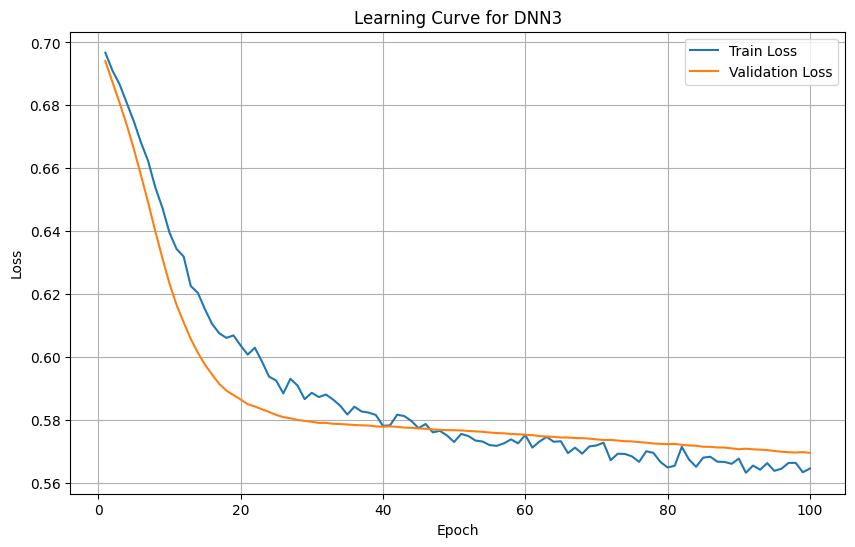

In [41]:
best_params=study.best_params
model = DNN_3(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              ).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN3')
plt.legend()
plt.grid()
plt.show()

Accuracy: 58.43%
Precision: 0.4791
Recall: 0.8791
F1 Score: 0.6202
Matthews Correlation Coefficient: 0.2977
Specificity: 0.3989


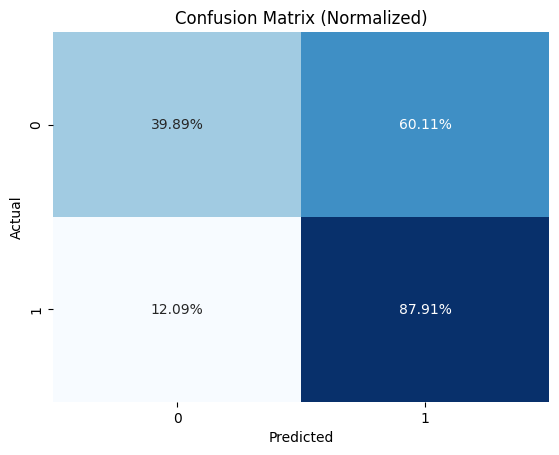

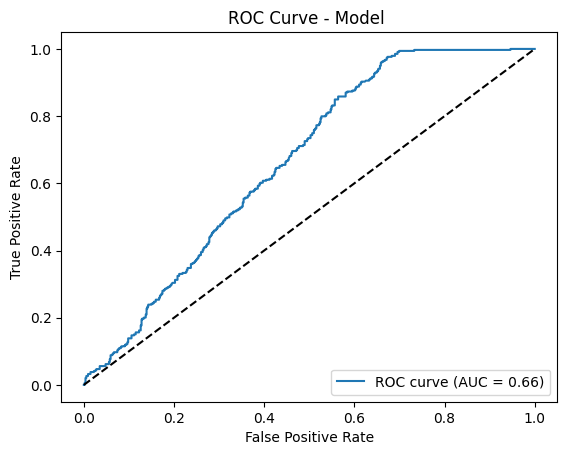

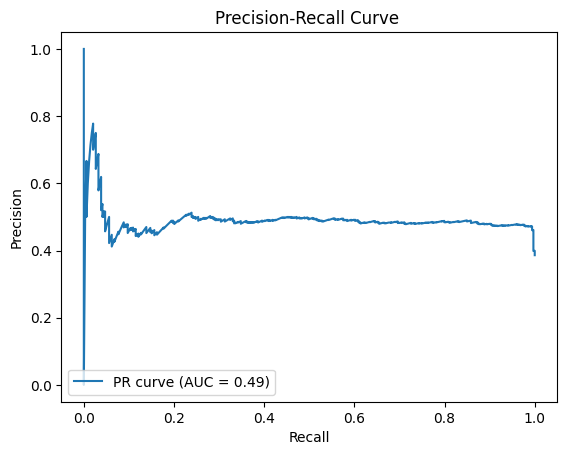

In [42]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >0.49).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [43]:
# モデルと構造を保存
torch.save(model.state_dict(), '../../saved_model/DNN_3.pth')

